Import relevant libraries

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Import the Datasets

In [184]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

#create a sale price column for the test data and populate it

test['SalePrice'] = 'TEST'

#merge the data sets so I can do all transformations at the same time

housing = pd.concat([train, test])

convert columns to snake case

In [185]:
housing = housing.rename(columns = str.lower)
housing.columns = housing.columns.str.replace(' ','_')

In [186]:
housing.isnull().sum().sum()

13993

In [187]:
housing.isnull().sum().to_dict()

{'id': 0,
 'pid': 0,
 'ms_subclass': 0,
 'ms_zoning': 0,
 'lot_frontage': 490,
 'lot_area': 0,
 'street': 0,
 'alley': 2731,
 'lot_shape': 0,
 'land_contour': 0,
 'utilities': 0,
 'lot_config': 0,
 'land_slope': 0,
 'neighborhood': 0,
 'condition_1': 0,
 'condition_2': 0,
 'bldg_type': 0,
 'house_style': 0,
 'overall_qual': 0,
 'overall_cond': 0,
 'year_built': 0,
 'year_remod/add': 0,
 'roof_style': 0,
 'roof_matl': 0,
 'exterior_1st': 0,
 'exterior_2nd': 0,
 'mas_vnr_type': 23,
 'mas_vnr_area': 23,
 'exter_qual': 0,
 'exter_cond': 0,
 'foundation': 0,
 'bsmt_qual': 80,
 'bsmt_cond': 80,
 'bsmt_exposure': 83,
 'bsmtfin_type_1': 80,
 'bsmtfin_sf_1': 1,
 'bsmtfin_type_2': 81,
 'bsmtfin_sf_2': 1,
 'bsmt_unf_sf': 1,
 'total_bsmt_sf': 1,
 'heating': 0,
 'heating_qc': 0,
 'central_air': 0,
 'electrical': 1,
 '1st_flr_sf': 0,
 '2nd_flr_sf': 0,
 'low_qual_fin_sf': 0,
 'gr_liv_area': 0,
 'bsmt_full_bath': 2,
 'bsmt_half_bath': 2,
 'full_bath': 0,
 'half_bath': 0,
 'bedroom_abvgr': 0,
 'kitchen

Some potential problems with null values:
lot frontage is missing 490 values, which is almost 1/6 of our data.  We can just drop this column and perform our regression wihout it, since it is unlikely that a buyer of a residential property is concerned with street frontage, and also I do not believe there is a good practice for filling this much null data.

alley has over 2700 null values, but null in this case means no access. can make this into a dummy

fireplace quality has 1422 nulls, but again that just means no fireplace

Fence is missing a significant amount of data as well, but again null indicates no fence

pool quality same situation as fence

misc feature is mostly null, but this column can be dropped because the relevant information is captured in misc value

In [188]:
# Drop the lot frontage column
housing.drop(columns = ['lot_frontage'], axis = 1 , inplace = True)

In [189]:
#create a bool to indicate whether a house has a good wood fence or better. 
#This variable really just serves to indicate whether a house has good privacy or not

housing['fence'] = housing['fence'].apply(
    lambda x: 1 if x == 'GdPrv' or x == 'GdWo' else 0)

In [190]:
housing['fence'].value_counts()

0    2699
1     230
Name: fence, dtype: int64

Convert street into a bool, 1 for paved 0 for gravel

In [191]:
housing['street'] = housing['street'].apply(
    lambda x: 1 if x == 'Paved' else 0)

Central air can be a bool, as it simply represents whether a house has central air conditioning or not

In [192]:
housing['central_air'] = housing['central_air'].apply(
    lambda x: 1 if x == 'Y' else 0)

garage type is too complicated of a variable, can be reduced to just attached or unattached for modeling purposes since I don't think humans distinctly value what type of attached garage a house has

In [193]:
housing['garage_type'].value_counts()

Attchd     1731
Detchd      782
BuiltIn     185
Basment      36
2Types       23
CarPort      15
Name: garage_type, dtype: int64

In [194]:
housing['garage_type'] = housing['garage_type'].apply(
    lambda x: 1 if x in ['Attchd','Basment', 'BuiltIn','2Types'] else 0)

housing.rename(columns = {'garage_type':'garage_att'},inplace = True)

Alley can be turned into a bool which indicates whether the house is accessible by alley or not

In [195]:
housing['alley'].value_counts()

Grvl    120
Pave     78
Name: alley, dtype: int64

In [196]:
housing['alley'] = housing['alley'].apply(
    lambda x: 1 if x in ['Grvl', 'Pave'] else 0)

All of the different types of deck/porch can be represented by a single variable which represents the total square footage of the deck/decks

In [197]:
housing['deck_space'] = (housing['wood_deck_sf'] + 
                         housing['open_porch_sf'] + 
                         housing['enclosed_porch'] +
                         housing['3ssn_porch'] +
                         housing['screen_porch'])                                                                                 

drop the old deck columns since we have captured them in our new variable

In [198]:
housing.drop(columns = ['wood_deck_sf',
                        'open_porch_sf',
                        'enclosed_porch',
                        '3ssn_porch',
                        'screen_porch'], axis = 1, inplace = True)

simplify pool quality and pool area to a dummy that represents if a house has a pool or not, drop the other pool columns since there are so few of them it doesn't make sense to keep all those variables

In [199]:
housing['has_pool'] = housing['pool_area'].apply(lambda x: 1 if x > 0 else 0)

housing.drop(columns = ['pool_area', 'pool_qc'], inplace = True)

Split lot shape into regular vs irregular, dummy 1 for regular shape, 0 for irregular

In [200]:
housing['lot_shape'] = housing['lot_shape'].apply(
    lambda x: 1 if x == 'Reg' else 0)

for lot_config, corner lots are typically more desirable as they tend to be large, so create a bool for whether a parcel is a corner lot

In [201]:
#create a function to determine if a lot is a corner lot
housing['corner_lot'] = housing['lot_config'].apply(
    lambda x: 1 if x == 'Corner' else 0)

#drop the old column
housing.drop(columns = ['lot_config'],axis = 1, inplace = True)

drop misc feature column, but keep misc val. don't need to know specifically what the feature is if we have the feature's value

In [202]:
housing.drop(columns = ['misc_feature'], axis = 1, inplace = True)

fill the null values for masonry facade area, as the null houses have no facade

In [203]:
housing['mas_vnr_area'].fillna(0, inplace = True)

make a variable for total half baths and total full baths, drop the old columns since I don't care where the bathrooms are located in the home

In [204]:
housing['half_bath_tot'] = housing['bsmt_half_bath'] + housing['half_bath']

In [205]:
housing['full_bath_tot'] = housing['full_bath'] + housing['bsmt_full_bath']

In [206]:
housing.drop(columns = ['bsmt_half_bath','half_bath','full_bath',
                        'bsmt_full_bath'], axis = 1, inplace = True)

drop the old 1st/2nd floor sf splits since theres a variable that contains both, and these will cause issues with multicolinearity 

In [207]:
housing.drop(columns = ['1st_flr_sf','2nd_flr_sf'], axis = 1, inplace = True)

Drop garage car, keep sf. redundant

In [208]:
housing.drop(columns = ['garage_cars'], axis = 1, inplace = True)

fill null value for garage area with 0, since these houses simply don't have a garage

In [209]:
housing['garage_area'].fillna(0, inplace = True)

Create a column for total finished basement square footage, drop the unneccessary basement columns

In [210]:
housing['finished_bsmt_sqft'] = (housing['total_bsmt_sf'] - 
                                 housing['bsmt_unf_sf'])

In [211]:
housing['total_bsmt_sf'].fillna(0, inplace = True)

In [212]:
housing.drop(columns = ['bsmt_exposure',
                        'bsmtfin_type_1',
                        'bsmtfin_sf_1',
                        'bsmtfin_type_2',
                        'bsmtfin_sf_2',
                        'bsmt_unf_sf'], axis = 1, inplace = True)

# Tackling Categorical Variables

#### My goal for these categorical variables is generally to create boolean variables whenever possible that capture the general qualities represented by the categorical variables without significantly increasing my number of variables

Drop the zoning variable. we are attempting to value the existing structure, if a property is selling because it is going to be torn down then we are not valuing the structure, we are only valuing the land, and thus none of the physical characteristics of the house will be relevant. 

In [213]:
housing.drop(columns = ['ms_zoning'], axis = 1, inplace = True)

drop ms_subclass variable, the primary purpose of this subgroup is to indicate the age and physical characteristics of the structure which are better captured in other variables

In [214]:
housing.drop(columns = ['ms_subclass'], axis = 1, inplace = True)

Create a bool for land contour which indicates 1 = flat, 2 = not flat

In [215]:
housing['land_contour'] = housing['land_contour'].apply(
    lambda x: 1 if x == 'Lvl' else 0)

drop slope because it should be covered by contour, and even if it isn't it will display a high level of covariance with contour

In [216]:
housing.drop(columns = ['land_slope'], axis = 1, inplace = True)

create a bool for if a house has all public utilities or not

In [217]:
housing['utilities'] = housing['utilities'].apply(
    lambda x: 1 if x == 'AllPub' else 0)

create dummies for neighborhood since we see a significant difference between house sale prices in various neighborhoods

In [218]:
housing = pd.get_dummies(housing, columns = ['neighborhood'], 
                         drop_first = True)

create a bool for if a house is close to a positive offsite feature (park, greenbelt, etc), and do the same thing for condition 2

In [219]:
housing['condition_1'] = housing['condition_1'].apply(
    lambda x: 1 if x in ['PosN', 'PosA'] else 0)
housing['condition_2'] = housing['condition_2'].apply(
    lambda x: 1 if x in ['PosN', 'PosA'] else 0)

In [220]:
#temporarily split train/test data so we can examine how different variables impact sale price
a = housing[housing['saleprice'] != 'TEST']
a['saleprice'] = pd.to_numeric(a['saleprice'])

<ipython-input-220-54a44a78ef42>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['saleprice'] = pd.to_numeric(a['saleprice'])


In [221]:
a.groupby('condition_1')['saleprice'].mean()

condition_1
0    180048.763419
1    254775.538462
Name: saleprice, dtype: float64

In [222]:
a.groupby('condition_2')['saleprice'].mean()

condition_2
0    180848.585819
1    393166.666667
Name: saleprice, dtype: float64

the new condition 1 and 2  variables show some potentially significant impacts on saleprice, with condition_1 = 1 adding roughly 70k in value and condition_2 adding nearly 200k

Get dummies for building type

In [223]:
housing = pd.get_dummies(housing, columns = ['bldg_type'], drop_first = True)

drop house style as it is an overly simplistic cat variable better captured in other variables

In [224]:
housing.drop(columns = ['house_style'], inplace = True)

overall quality and condition

Text(0, 0.5, 'Count')

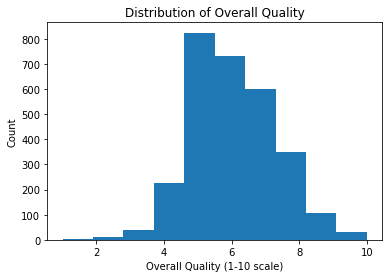

In [225]:
plt.hist(housing['overall_qual'])
plt.title('Distribution of Overall Quality')
plt.xlabel('Overall Quality (1-10 scale)')
plt.ylabel('Count')

In [226]:
a.groupby('overall_qual')['saleprice'].mean()

overall_qual
1      48725.000000
2      51081.000000
3      81309.103448
4     107744.037736
5     134963.644760
6     162891.102767
7     203430.285383
8     271437.044000
9     370197.376623
10    417396.565217
Name: saleprice, dtype: float64

Text(0, 0.5, 'Count')

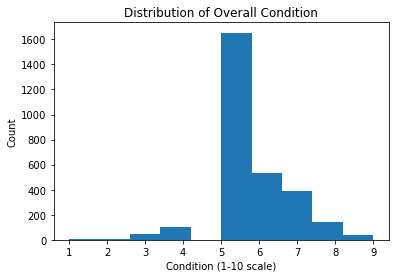

In [227]:
plt.hist(housing['overall_cond'])
plt.title('Distribution of Overall Condition')
plt.xlabel('Condition (1-10 scale)')
plt.ylabel('Count')

In [228]:
housing['overall_cond'].value_counts(normalize = True)

5    0.564356
6    0.181973
7    0.133151
8    0.049164
4    0.034483
3    0.017071
9    0.013998
2    0.003414
1    0.002390
Name: overall_cond, dtype: float64

Nearly 60% of all observations are coded with a 5 out of 10 for overall condition, with almost all of the data receiving a 5 or higher. This is likely because assessors are unwilling to score a property with less than a 5 except in the most extreme circumstances. Because of this I will create a bool for if a house receives less than a 5, which will likely lower its value significantly. On the other hand, overall condition is a much more normally distributed variable that seems increase value more linearly. 

Create a bool for condition where condition = 1 means the house is in 5 or greater shape

In [229]:
housing['overall_cond'] = housing['overall_cond'].apply(
    lambda x: 0 if x < 5 else 1)

bool for roof style 1 if hip, flat, or shed

In [230]:
a.groupby('roof_style')['saleprice'].mean()

roof_style
Flat       191613.076923
Gable      171264.253243
Gambrel    138208.333333
Hip        224366.654912
Mansard    152642.857143
Shed       208666.666667
Name: saleprice, dtype: float64

In [231]:
housing['roof_style'] = housing['roof_style'].apply(
    lambda x: 1 if x in ['Flat','Hip','Shed'] else 0)

Roof mat is such a skewed variable that it doesn't make sense to make estimations on so few observations of non composite shingle roofs, and so we drop the variable

Text(0, 0.5, 'Count')

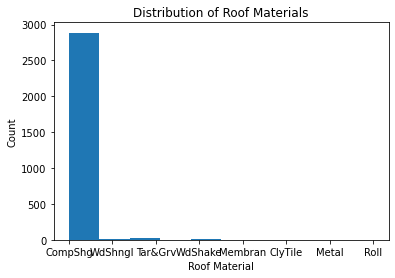

In [232]:
plt.hist(housing['roof_matl'])
plt.title('Distribution of Roof Materials')
plt.xlabel('Roof Material')
plt.ylabel('Count')

In [233]:
housing.drop(columns = ['roof_matl'], inplace = True)

Bool for external material indicating whether a house has vinyl siding or hard board (both are considered to be the most durable siding options), same for exterior second. we see noticeable differences in sale price for houses that display these desireable traits.

In [234]:
a.groupby('exterior_1st')['saleprice'].mean()

exterior_1st
AsbShng    103183.333333
AsphShn     82375.000000
BrkComm    131000.000000
BrkFace    193055.093750
CBlock      93250.000000
CemntBd    243429.088889
HdBoard    159582.473333
ImStucc    262000.000000
MetalSd    154402.048338
Plywood    170511.453947
Stone      258500.000000
Stucco     139712.962963
VinylSd    218174.082873
Wd Sdng    142940.887681
WdShing    155616.822222
Name: saleprice, dtype: float64

In [235]:
housing['exterior_1st'].value_counts()

VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     420
Plywood     221
CemntBd     125
BrkFace      88
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
CBlock        2
Stone         2
AsphShn       2
PreCast       1
ImStucc       1
Name: exterior_1st, dtype: int64

In [236]:
housing['exterior_1st'] = housing['exterior_1st'].apply(
    lambda x: 1 if x in ['VinylSd', 'HdBoard'] else 0)

housing['exterior_2nd'] = housing['exterior_2nd'].apply(
    lambda x: 1 if x in ['VinylSd', 'HdBoard'] else 0)


Dummy for external quality being either excellent or good 

In [237]:
housing['exter_qual'] = housing['exter_qual'].apply(
    lambda x: 1 if x == 'Ex' or x == 'Gd' else 0)

Dummy for foundation type 1 = poured concrete

In [238]:
a.groupby('foundation')['saleprice'].mean()

foundation
BrkTil    129050.190045
CBlock    148415.530707
PConc     227676.483801
Slab      108810.676471
Stone     143235.200000
Wood      173750.000000
Name: saleprice, dtype: float64

In [239]:
housing['foundation'].value_counts()

PConc     1309
CBlock    1244
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: foundation, dtype: int64

In [240]:
housing['foundation'] = housing['foundation'].apply(
    lambda x: 1 if x =='PConc' else 0)

bool for basement quality good or excellent = 1

In [241]:
a.groupby('bsmt_qual')['saleprice'].mean()

bsmt_qual
Ex    329506.619565
Fa    107752.166667
Gd    202537.582176
Po     89000.000000
TA    139988.461105
Name: saleprice, dtype: float64

In [242]:
housing['bsmt_qual'].value_counts()

TA    1283
Gd    1219
Ex     257
Fa      88
Po       2
Name: bsmt_qual, dtype: int64

In [243]:
housing['bsmt_qual'] = housing['bsmt_qual'].apply(
    lambda x: 1 if x in ['Gd','Ex'] else 0)

Basement condition is very poorly distributed and does not appear to have a massive impact on sale price, and so we can drop the variable. 

In [244]:
a.groupby('bsmt_cond')['saleprice'].mean()

bsmt_cond
Ex    195000.000000
Fa    118629.076923
Gd    223969.550562
Po    124063.200000
TA    184021.858233
Name: saleprice, dtype: float64

In [245]:
housing['bsmt_cond'].value_counts()

TA    2615
Gd     122
Fa     104
Po       5
Ex       3
Name: bsmt_cond, dtype: int64

In [246]:
housing.drop(columns = ['bsmt_cond'], inplace = True)

Dummy for excellent heating quality, 1 = excellent

In [247]:
housing['heating_qc'].value_counts()

Ex    1494
TA     864
Gd     476
Fa      92
Po       3
Name: heating_qc, dtype: int64

In [248]:
housing = pd.get_dummies(housing, columns = ['heating_qc'], drop_first= True)

In [249]:
housing.drop(columns = ['heating_qc_Gd',
                       'heating_qc_TA',
                       'heating_qc_Fa',
                       'heating_qc_Po'], axis = 1, inplace = True)

Drop garage year built since it has a high degree of multicolinearity with year built

In [250]:
housing.drop(columns = ['garage_yr_blt'], axis = 1, inplace = True)

Create a dummy for garage finish, combining rough and finished vs unfinished

In [251]:
housing['garage_finish'] = housing['garage_finish'].apply(
    lambda x: 1 if x in ['Fin', 'Rfn'] else 0)

Create a bool for whether a house has a brick or stone facade, zero out the mas_vnr_area variable if it is not brick or stone, drop the material column

In [252]:
a.groupby('mas_vnr_type')['saleprice'].mean()

mas_vnr_type
BrkCmn     144515.692308
BrkFace    212161.436508
None       153679.275862
Stone      263714.702381
Name: saleprice, dtype: float64

In [253]:
housing['mas_vnr_type'].value_counts()

None       1752
BrkFace     880
Stone       248
BrkCmn       25
CBlock        1
Name: mas_vnr_type, dtype: int64

In [254]:
housing['mas_vnr_type'] = housing['mas_vnr_type'].apply(
    lambda x: 1 if x in ['BrkFace', 'Stone'] else 0)

Drop external cond variable because of distribution issues and also multicolinearity

In [255]:
housing.drop(columns = ['exter_cond'], inplace = True)

Electrical bool for standard circuit breaker or not

In [256]:
housing['electrical'] = housing['electrical'].apply(
    lambda x: 1 if x == 'SBrkr' else 0)

Drop functional column as very few houses receive anything more than a minor deduction

In [257]:
a.groupby('functional')['saleprice'].mean()

functional
Maj1    163106.166667
Maj2     87157.714286
Min1    154429.761905
Min2    150424.571429
Mod     148108.724138
Sal      31550.000000
Sev      95750.000000
Typ     183954.749347
Name: saleprice, dtype: float64

In [258]:
housing['functional'].value_counts()

Typ     2727
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sal        2
Sev        2
Name: functional, dtype: int64

In [259]:
housing.drop(columns = ['functional'], inplace = True)

Drop heating variable as basically the entire dataset is GasA

In [260]:
housing['heating'].value_counts()

GasA     2884
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: heating, dtype: int64

In [261]:
housing.drop(columns = ['heating'], inplace = True)

Drop sale type, most of the data is warranty deed, and the next largest category is new construction which is captured by year built and sale date. 

In [262]:
housing['sale_type'].value_counts()

WD       2536
New       238
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: sale_type, dtype: int64

In [263]:
housing.drop(columns = ['sale_type'], inplace = True)

Create a bool for if a kitchen is good or excellent, since these seem to increase the value of a house signficantly

In [264]:
housing['kitchen_qual'].value_counts()

TA    1494
Gd    1160
Ex     204
Fa      70
Po       1
Name: kitchen_qual, dtype: int64

In [265]:
a.groupby('kitchen_qual')['saleprice'].mean()

kitchen_qual
Ex    336424.463576
Fa    101334.957447
Gd    211629.451613
TA    139501.607450
Name: saleprice, dtype: float64

In [266]:
housing['kitchen_qual'] = housing['kitchen_qual'].apply(
    lambda x: 1  if x in ['Gd','Ex'] else 0)

Create a bool for paved driveway since having a paved driveway seems to increase the value of a home

In [267]:
a.groupby('paved_drive')['saleprice'].mean()

paved_drive
N    104562.827815
P    129824.461538
Y    188792.163890
Name: saleprice, dtype: float64

In [268]:
housing['paved_drive'].value_counts()

Y    2651
N     216
P      62
Name: paved_drive, dtype: int64

In [269]:
housing['paved_drive'] = housing['paved_drive'].apply(
    lambda x: 1 if x == 'Y' else 0)

Drop fireplace quality and the unnecessary garage columns 

In [270]:
housing.drop(columns = ['fireplace_qu','garage_att','garage_qual',
                        'garage_cond'], inplace = True)

### Checking Dtypes

In [271]:
housing.dtypes.to_dict()

{'id': dtype('int64'),
 'pid': dtype('int64'),
 'lot_area': dtype('int64'),
 'street': dtype('int64'),
 'alley': dtype('int64'),
 'lot_shape': dtype('int64'),
 'land_contour': dtype('int64'),
 'utilities': dtype('int64'),
 'condition_1': dtype('int64'),
 'condition_2': dtype('int64'),
 'overall_qual': dtype('int64'),
 'overall_cond': dtype('int64'),
 'year_built': dtype('int64'),
 'year_remod/add': dtype('int64'),
 'roof_style': dtype('int64'),
 'exterior_1st': dtype('int64'),
 'exterior_2nd': dtype('int64'),
 'mas_vnr_type': dtype('int64'),
 'mas_vnr_area': dtype('float64'),
 'exter_qual': dtype('int64'),
 'foundation': dtype('int64'),
 'bsmt_qual': dtype('int64'),
 'total_bsmt_sf': dtype('float64'),
 'central_air': dtype('int64'),
 'electrical': dtype('int64'),
 'low_qual_fin_sf': dtype('int64'),
 'gr_liv_area': dtype('int64'),
 'bedroom_abvgr': dtype('int64'),
 'kitchen_abvgr': dtype('int64'),
 'kitchen_qual': dtype('int64'),
 'totrms_abvgrd': dtype('int64'),
 'fireplaces': dtype('i

### Splitting the DF into train and test again

In [272]:
#There are 3 rows with null values, all in the train data, so we drop them. 

housing.dropna(inplace = True)

In [273]:
train = housing[housing['saleprice'] != 'TEST']
train['saleprice'] = pd.to_numeric(train['saleprice'])
test = housing[housing['saleprice'] == 'TEST']

<ipython-input-273-1e7c7f05f88c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['saleprice'] = pd.to_numeric(train['saleprice'])


In [274]:
train.to_csv('../datasets/housing_cleaned.csv')
test.to_csv('../datasets/test_cleaned.csv')

In [275]:
test = pd.read_csv('../datasets/test_cleaned.csv')
test.shape

(878, 78)

In [276]:
housing.isnull().sum().to_dict()

{'id': 0,
 'pid': 0,
 'lot_area': 0,
 'street': 0,
 'alley': 0,
 'lot_shape': 0,
 'land_contour': 0,
 'utilities': 0,
 'condition_1': 0,
 'condition_2': 0,
 'overall_qual': 0,
 'overall_cond': 0,
 'year_built': 0,
 'year_remod/add': 0,
 'roof_style': 0,
 'exterior_1st': 0,
 'exterior_2nd': 0,
 'mas_vnr_type': 0,
 'mas_vnr_area': 0,
 'exter_qual': 0,
 'foundation': 0,
 'bsmt_qual': 0,
 'total_bsmt_sf': 0,
 'central_air': 0,
 'electrical': 0,
 'low_qual_fin_sf': 0,
 'gr_liv_area': 0,
 'bedroom_abvgr': 0,
 'kitchen_abvgr': 0,
 'kitchen_qual': 0,
 'totrms_abvgrd': 0,
 'fireplaces': 0,
 'garage_finish': 0,
 'garage_area': 0,
 'paved_drive': 0,
 'fence': 0,
 'misc_val': 0,
 'mo_sold': 0,
 'yr_sold': 0,
 'saleprice': 0,
 'deck_space': 0,
 'has_pool': 0,
 'corner_lot': 0,
 'half_bath_tot': 0,
 'full_bath_tot': 0,
 'finished_bsmt_sqft': 0,
 'neighborhood_Blueste': 0,
 'neighborhood_BrDale': 0,
 'neighborhood_BrkSide': 0,
 'neighborhood_ClearCr': 0,
 'neighborhood_CollgCr': 0,
 'neighborhood_Cra

# Dealing with Outliers

#### there are a few obvious outliers that the data dictionary warns us about, so we will examine those first. 

In [277]:
train = pd.read_csv('../datasets/housing_cleaned.csv')

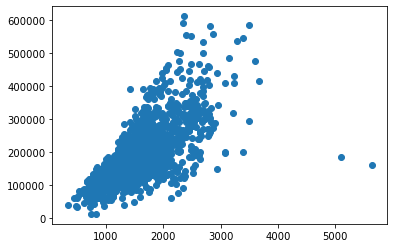

In [278]:
plt.scatter(train['gr_liv_area'], train['saleprice'])

The data dictionary provided with this exercise suggests removing houses with more than 4000 SQFT of area, and I am inclined to agree with them.

In [279]:
train = train[train['gr_liv_area'] < 4000]

Text(0, 0.5, 'Count')

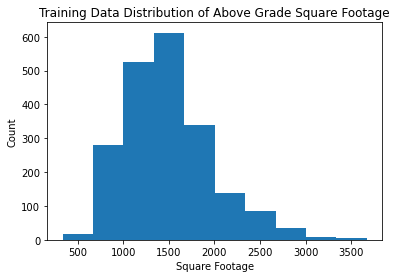

In [280]:
plt.hist(train['gr_liv_area'])
plt.title('Training Data Distribution of Above Grade Square Footage')
plt.xlabel('Square Footage')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

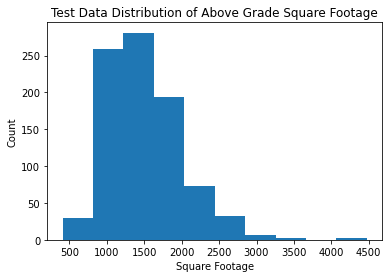

In [281]:
plt.hist(test['gr_liv_area'])
plt.title('Test Data Distribution of Above Grade Square Footage')
plt.xlabel('Square Footage')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

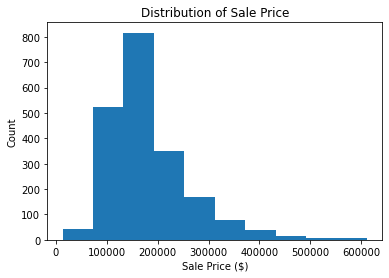

In [282]:
plt.hist(train['saleprice'])
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price ($)')
plt.ylabel('Count')

Removing outliers for sale price (outlier being defined as > 3 std devs from mean)

In [283]:
train['saleprice'].describe()

count      2047.000000
mean     181478.655594
std       79269.463865
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: saleprice, dtype: float64

In [284]:
# sale_std = 79269.46

# upper_bound = train['saleprice'].mean() + (3 * sale_std)

# train = train[train['saleprice'] < upper_bound]

Initially I wanted to drop the highest value "outlier" houses in terms of sale price, as I thought that including really expensive homes in my dataset would hinder my model's ability to accurately predict the majority of the data. Ultimately removing the outliers actually reduced the performance of my model in terms of RMSE on the testing data, so I elected to include these outliers.

In [285]:
train.shape

(2047, 78)

In [286]:
train.to_csv('../datasets/housing_cleaned.csv', index = False)

In [287]:
print('done!')

done!
